---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 4

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))
P1_Graphs

In [3]:
for graph in P1_Graphs:
    print(graph)

barabasi_albert_graph(1000,2)
watts_strogatz_graph(1000,10,0.05)
watts_strogatz_graph(750,5,0.075)
barabasi_albert_graph(750,4)
watts_strogatz_graph(750,4,1)


<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

<IPython.core.display.Javascript object>


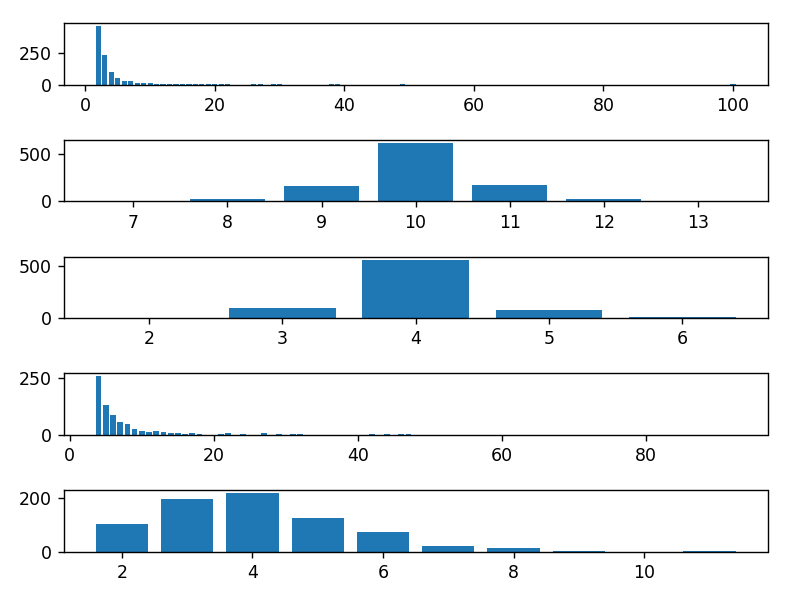

In [4]:
def if_PA(G):
    degrees = G.degree()
    dist = {}
    for node in degrees:
        degree = degrees[node]
        if degree not in dist:
            dist[degree] = 1
        else:
            dist[degree] += 1
    
    return list(dist.keys()), list(dist.values())

import matplotlib.pyplot as plt
%matplotlib notebook
for index, graph in enumerate(P1_Graphs):
    x, y = if_PA(graph)
    plt.subplot(5,1,index+1)
    plt.tight_layout()
    plt.bar(x, y)

<IPython.core.display.Javascript object>


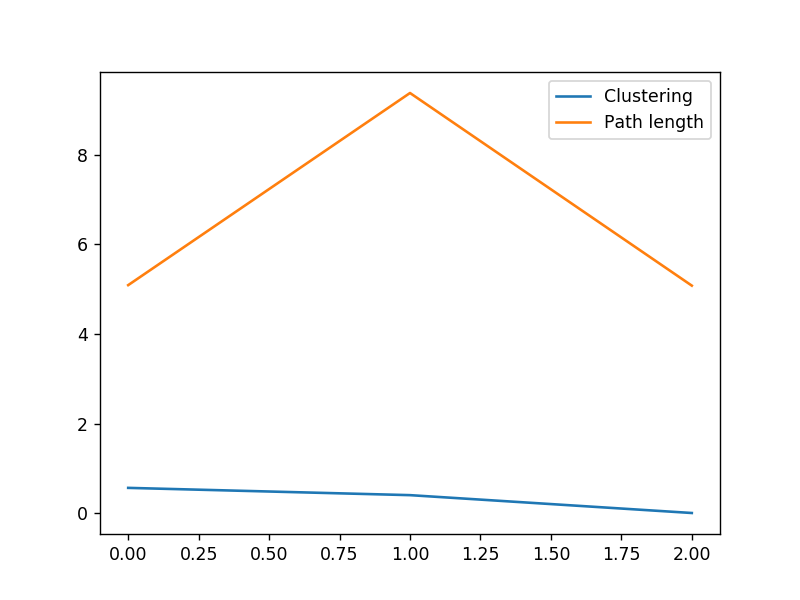

In [5]:
clusterings = [nx.average_clustering(P1_Graphs[i]) for i in [1, 2, 4]]
path_lengths = [nx.average_shortest_path_length(P1_Graphs[i]) for i in [1, 2, 4]]

plt.figure()
plt.plot(clusterings)
plt.plot(path_lengths)
plt.legend(['Clustering', 'Path length'])

In [6]:
def graph_identification():
    
    # Your Code Here
    
    return ['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

graph_identification()

['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

---

## Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [7]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [8]:
def salary_predictions():
    
    # Your Code Here
    from sklearn.ensemble import RandomForestClassifier
    
    df = pd.DataFrame(G.nodes(), columns=['node'])
    df['department'] = pd.Series(nx.get_node_attributes(G, 'Department'))
    df['management'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
    
    df['pg'] = pd.Series(nx.pagerank(G))
    df['between'] = pd.Series(nx.betweenness_centrality(G, k=20))
    df['to_management'] = df['node'].apply(lambda x: len([1 for y in G.edge[x] if G.node[y]['ManagementSalary']]))
    df['to_management'] = df['to_management'] / df['to_management'].max()
    
    train = df[df['management'] > -1].iloc[:, 1:]
    x_train = train.loc[:, ['department', 'pg', 'between', 'to_management']]
    y_train = train['management']
    
    clf = RandomForestClassifier(n_estimators=50, max_features=2, max_depth=3, n_jobs=-1, random_state=0).fit(x_train,y_train)
    
    output = df[np.isnan(df['management'])]
    x_output = output.loc[:, ['department', 'pg', 'between', 'to_management']]
    
    y_output = clf.predict_proba(x_output)[:, 1]
    
    return pd.Series(y_output, index=output['node'])

salary_predictions().head()

node
1     0.218052
2     0.776301
5     0.980515
8     0.091875
14    0.216410
dtype: float64

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [9]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [10]:
def new_connections_predictions():
    
    # Your Code Here
    from sklearn.ensemble import RandomForestClassifier
    
    df = future_connections.copy()
    df = df.reset_index()
    df['common'] = df['index'].apply(lambda x: len([1 for k in nx.common_neighbors(G, x[0], x[1])]))
    df['jaccard'] = pd.Series([x[2] for x in nx.jaccard_coefficient(G, df['index'])])
    df['pa'] = pd.Series([x[2] for x in nx.preferential_attachment(G, df['index'])])
    
    train = df[df['Future Connection'] > -1]
    x_train = train.loc[:, ['common', 'jaccard', 'pa']]
    y_train = train['Future Connection']
    
    clf = RandomForestClassifier(n_estimators=50, max_features=2, max_depth=3, n_jobs=-1, random_state=0).fit(x_train, y_train)
    
    output = df[np.isnan(df['Future Connection'])]
    x_output = output.loc[:, ['common', 'jaccard', 'pa']]
    
    y_output = clf.predict_proba(x_output)[:,1]
    
    return pd.Series(y_output, index=output['index'])

new_connections_predictions().head()

index
(107, 348)    0.019639
(542, 751)    0.018257
(20, 426)     0.588011
(50, 989)     0.018257
(942, 986)    0.018257
dtype: float64